In [1]:
from pathlib import Path
import sys
import os.path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns
from tqdm.notebook import tqdm
from pymodulon.compare import compare_ica
from pymodulon.core import IcaData
from pymodulon.io import load_json_model, save_to_json
from pymodulon.plotting import *

import json

from pymodulon.util import explained_variance
from pymodulon.imodulondb import imdb_gene_presence

%matplotlib inline
%config  InlineBackend.figure_format = 'png'

sns.set_style('whitegrid')

In [2]:
precise1k = load_json_model('../Data/p1k.json.gz')

In [3]:
biocyc_info = pd.read_csv('../Data/biocyc_info.txt', sep="\t")

In [4]:
def map_accession_to_gene_name(df, biocyc_info):

    # Reset index if 'Accession' is the index, and rename the column
    if df.index.name == 'Accession' or df.index.name is None:
        df = df.reset_index()
        df.rename(columns={'index': 'Accession'}, inplace=True)
        
    # Merge with biocyc_info to map 'Accession' to 'Gene Name'
    merged_df = df.merge(biocyc_info[['Accession', 'Gene Name']], on='Accession', how='left')

    # Identify rows with NaN 'Gene Name'
    removed_indices = merged_df[merged_df['Gene Name'].isna()]['Accession'].tolist()

    # Print the original indices that were removed
    print("Original indices removed due to NaN 'Gene Name':", removed_indices)

    # Set 'Gene Name' as the new index and drop the 'Accession' column
    merged_df.set_index('Gene Name', inplace=True)
    merged_df.drop(columns=['Accession'], inplace=True)

    # Remove rows with NaN as index
    merged_df = merged_df[merged_df.index.notna()]
    
    return merged_df

## Dictionary Learning

In [54]:
components_pca = pd.read_csv('./Results/NMF/M_NMF.csv', index_col=0)

In [55]:
components_pca

,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,Component_10,...,Component_241,Component_242,Component_243,Component_244,Component_245,Component_246,Component_247,Component_248,Component_249,Component_250
b0002,0.000000,0.112764,0.000000,0.000000,0.000000,0.220498,5.095283,1.442781,0.000000,0.634563,...,0.000000,0.123049,0.626179,0.189095,0.702714,0.000000,0.418881,0.213389,0.384390,0.067950
b0003,1.002155,0.575140,0.001007,0.230987,1.667022,0.424968,2.574688,0.448056,0.062559,0.519485,...,0.079004,0.162807,0.345215,0.073877,0.497688,0.048545,0.055262,0.156370,0.211369,0.053493
b0004,1.136490,0.606548,0.099842,0.228271,1.868402,0.458755,2.254894,0.449535,0.102258,0.514951,...,0.132307,0.127518,0.340548,0.054186,0.523311,0.053237,0.134112,0.150634,0.205731,0.088025
b0005,0.000000,0.000000,0.000000,0.016671,1.264674,0.607458,1.046731,0.000000,0.099355,0.314389,...,0.184579,0.142717,0.422932,0.033075,0.594330,0.032010,0.000000,0.060326,0.195203,0.203196
b0006,1.260157,0.400542,0.080629,0.439834,1.076129,0.000000,0.582143,0.245860,0.002272,0.223371,...,0.075831,0.082564,0.133472,0.010875,0.075195,0.038801,0.073791,0.040629,0.102513,0.064720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4747,0.000000,0.000000,0.000000,0.000000,0.000000,0.084967,0.000000,0.000000,0.000000,0.000000,...,0.056069,0.125647,0.000000,0.000000,0.000000,0.000000,0.000000,0.001084,0.002055,0.044972
b4748,0.000000,0.000000,0.000000,0.000000,0.000000,2.109682,0.000000,0.000000,0.000000,0.000000,...,0.250897,0.055594,0.209159,0.000000,0.000000,0.000000,0.000000,0.001278,0.191301,0.000000
b4751,0.000000,0.186183,0.003439,0.002204,0.470919,0.565428,0.007339,0.808226,0.004416,0.638408,...,0.003761,0.136102,0.305722,0.000000,0.296265,0.028798,0.230487,0.021123,0.260769,0.114616
b4755,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.041791,0.000000,0.000000,0.232502,0.000000,0.000000,0.072806,0.345135,0.200318


In [56]:
components_pca = map_accession_to_gene_name(components_pca, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [57]:
components_ica = map_accession_to_gene_name(precise1k.M, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [61]:
activities_pca = pd.read_csv('./Results/NMF/A_NMF.csv', index_col=0).T

In [62]:
PCA_Gene_Presence_Matrix = pd.read_csv("./Presence_Matrices/NMF_Gene_Presence_Matrix.csv", index_col=0).astype(int)

In [63]:
PCA_Gene_Presence_Matrix

,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,Component_10,...,Component_241,Component_242,Component_243,Component_244,Component_245,Component_246,Component_247,Component_248,Component_249,Component_250
b0002,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
b0003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b0004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b0005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b0006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4747,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b4748,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b4751,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b4755,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
import pandas as pd
import itertools
from sklearn.metrics import mutual_info_score
from tqdm.notebook import tqdm

def calculate_pairwise_mutual_information(df, top_n=20):
    """
    Calculate pairwise mutual information for all columns in a DataFrame 
    and return the top N pairs with the highest mutual information scores.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data (e.g., components_pca).
    top_n (int): The number of top pairs to return based on mutual information score.

    Returns:
    list: List of tuples (column1, column2, mutual_information_score) for the top N pairs.
    """
    # List to store mutual information scores for all pairs
    mutual_info_scores = []

    # Get all combinations of column pairs
    column_pairs = list(itertools.combinations(df.columns, 2))

    # Set up progress bar with the total number of combinations
    total_combinations = len(column_pairs)
    tqdm_bar = tqdm(column_pairs, total=total_combinations, desc="Processing column pairs", unit="pair")

    # Calculate mutual information for each pair of columns
    for col1, col2 in tqdm_bar:
        # Compute mutual information score between the two columns
        mi_score = mutual_info_score(df[col1], df[col2])
        # Append the result as a tuple (column1, column2, mi_score)
        mutual_info_scores.append((col1, col2, mi_score))

        # Update the progress bar description to show progress
        tqdm_bar.set_postfix({"Remaining pairs": total_combinations - len(mutual_info_scores)})

    # Sort the mutual information scores in descending order by the score
    mutual_info_scores.sort(key=lambda x: x[2], reverse=True)

    # Return the top N pairs with the highest mutual information scores
    return mutual_info_scores[:top_n]

In [65]:
top_20_pairs = calculate_pairwise_mutual_information(PCA_Gene_Presence_Matrix)

Processing column pairs:   0%|          | 0/31125 [00:00<?, ?pair/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

In [44]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def scatter_plot_with_outliers(df, col_x, col_y, threshold=4.7, save_as=None):
    """
    Creates a scatter plot of two specified columns from a dataframe,
    annotates outliers based on a threshold, and adjusts text to avoid overlap.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    col_x (str): The name of the column for the x-axis.
    col_y (str): The name of the column for the y-axis.
    threshold (float): The number of standard deviations away from the mean to consider a point as an outlier.
    save_as (str): Path to save the figure as an SVG file. If None, the plot will just be shown.
    """
    # Load the custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    # Compute the mean and standard deviation for each component
    mean_x = df[col_x].mean()
    std_x = df[col_x].std()

    mean_y = df[col_y].mean()
    std_y = df[col_y].std()

    # Identify outliers in both col_x and col_y
    outliers = df[
        (df[col_x] > mean_x + threshold * std_x) | 
        (df[col_x] < mean_x - threshold * std_x) |
        (df[col_y] > mean_y + threshold * std_y) |
        (df[col_y] < mean_y - threshold * std_y)
    ]
    
    # Non-outliers
    non_outliers = df.drop(outliers.index)

    # Scatter plot of col_x vs col_y
    plt.figure(figsize=(5, 5))

    # Plot non-outliers in light grey
    plt.scatter(non_outliers[col_x], non_outliers[col_y], alpha=0.7, label="Non-Outliers", color='lightgrey')

    # Plot outliers in #b899c8 color
    plt.scatter(outliers[col_x], outliers[col_y], alpha=0.7, label="Outliers", color='#b899c8')

    # Annotate outliers
    texts = []
    for idx, row in outliers.iterrows():
        # Add text slightly offset from the point to avoid overlap
        texts.append(plt.text(row[col_x], row[col_y], str(idx), fontsize=9, 
                              color='black', fontproperties=font_prop))

    # Adjust text positions to prevent overlap with points and other text
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), 
                force_points=0.3, force_text=0.3, 
                expand_points=(1.5, 1.5),  # Ensure distance between points and text
                expand_text=(1.5, 1.5))    # Ensure distance between text elements

    # Set font for plot title, labels, and tick labels
    plt.title(f'Scatter Plot: {col_x} vs {col_y} (With Genes Annotated)', fontproperties=font_prop)
    plt.xlabel(col_x, fontproperties=font_prop)
    plt.ylabel(col_y, fontproperties=font_prop)

    # Customize tick labels to use the custom font
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)

    # Remove the grid
    plt.grid(False)

    # Add a black box around the plot
    ax = plt.gca()  # Get current axis
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Plot formatting
    # plt.legend(False)

    # Save plot as SVG if save_as path is provided
    if save_as:
        plt.savefig(save_as, format='svg', bbox_inches='tight')

    # Show the plot if save_as is not provided
    else:
        plt.show()


In [67]:
top_20_pairs

[('Component_39', 'Component_47', 0.07468150376909896),
 ('Component_7', 'Component_20', 0.06744368127869772),
 ('Component_10', 'Component_221', 0.05177601342432511),
 ('Component_37', 'Component_39', 0.049404468403934365),
 ('Component_20', 'Component_121', 0.04568024608318849),
 ('Component_7', 'Component_121', 0.04134757788778934),
 ('Component_10', 'Component_84', 0.0401756563766425),
 ('Component_47', 'Component_75', 0.0376725668669974),
 ('Component_84', 'Component_221', 0.036989084924066946),
 ('Component_2', 'Component_7', 0.036158655402231676),
 ('Component_11', 'Component_143', 0.035691465865304875),
 ('Component_11', 'Component_159', 0.03359198483447509),
 ('Component_101', 'Component_212', 0.033385956379849695),
 ('Component_37', 'Component_89', 0.03261393536379885),
 ('Component_10', 'Component_101', 0.032177470973958074),
 ('Component_37', 'Component_47', 0.03204074298481559),
 ('Component_84', 'Component_101', 0.03123976470466291),
 ('Component_2', 'Component_20', 0.029

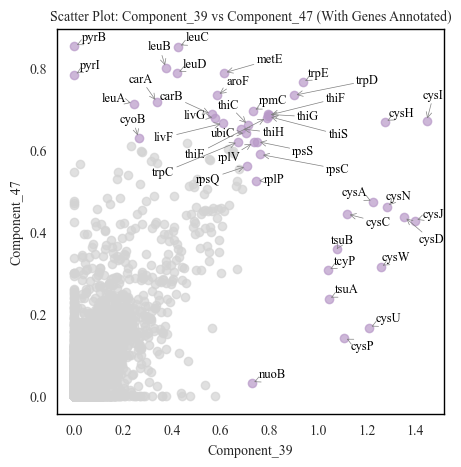

In [70]:
scatter_plot_with_outliers(components_pca, 'Component_39', 'Component_47', threshold=5)

## Color Update

In [125]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def scatter_plot_with_annotations(df, col_x, col_y, 
                                  list1, list2, list3=None, list4=None, list5=None, list6=None, 
                                  x_label=None, y_label=None, save_as=None, ):
    """
    Creates a scatter plot of two specified columns from a dataframe,
    colors points based on up to six input lists of row indices, and annotates points from these lists.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    col_x (str): The name of the column for the x-axis.
    col_y (str): The name of the column for the y-axis.
    list1 (list): List of row indices for points to be colored in #f6cd82.
    list2 (list): List of row indices for points to be colored in #b899c8.
    list3 (list, optional): List of row indices for points to be colored in #94c47d. Default is None.
    list4 (list, optional): List of row indices for points to be colored in #1f77b4. Default is None.
    list5 (list, optional): List of row indices for points to be colored in #d62728. Default is None.
    list6 (list, optional): List of row indices for points to be colored in #ff7f0e. Default is None.
    x_label (str, optional): Custom label for the x-axis. If None, col_x is used.
    y_label (str, optional): Custom label for the y-axis. If None, col_y is used.
    save_as (str, optional): Path to save the figure as an SVG file. If None, the plot will just be shown.
    """
    # Load the custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Prepare the subsets for each list of points
    points_lists = [list1, list2, list3, list4, list5, list6]
    colors = ['#f6cd82', '#b899c8', '#94c47d', '#ff7f0e', '#d62728', '#1f77b4']
    
    # Filter points for each list, ignoring None
    points_data = [df.loc[plist] if plist else None for plist in points_lists]

    # Collect indices from all valid lists to exclude them from 'other points'
    all_indices = [idx for plist in points_lists if plist for idx in plist]
    other_points = df.drop(all_indices)

    # Scatter plot setup
    plt.figure(figsize=(7, 7))

    # Plot other points in light grey
    plt.scatter(other_points[col_x], other_points[col_y], alpha=0.7, color='lightgrey')

    # Plot points from each provided list with respective colors
    texts = []  # Collect text objects for annotation adjustment
    for pdata, color in zip(points_data, colors):
        if pdata is not None:
            plt.scatter(pdata[col_x], pdata[col_y], alpha=0.7, color=color)
            for idx, row in pdata.iterrows():
                texts.append(plt.text(row[col_x], row[col_y], str(idx), fontsize=9, 
                                      color='black', fontproperties=font_prop))

    # Adjust text to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), 
                force_points=0.3, force_text=0.3, 
                expand_points=(1.5, 1.5), expand_text=(1.5, 1.5))

    # Set x and y labels
    plt.xlabel(x_label if x_label else col_x, fontproperties=font_prop)
    plt.ylabel(y_label if y_label else col_y, fontproperties=font_prop)

    # Customize tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)

    # Remove the grid
    plt.grid(False)

    # Add a black box around the plot
    ax = plt.gca()  # Get current axis
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Save or show the plot
    if save_as:
        plt.savefig(save_as, format='svg', bbox_inches='tight')
    else:
        plt.show()


In [126]:
list1 = ['pyrB', 'pyrI', 'carB', 'carA', 'uraA']

In [127]:
list2 = ['leuC', 'leuB', 'leuD', 'leuD', 'leuA']

In [128]:
list3 = ['thiE', 'thiF', 'thiS', 'thiC', 'thiG', 'thiH']

In [129]:
list4 = ['cysP', 'cysW', 'cysU', 'cysD', 'cysJ', 'cysI', 'cysN', 'cysA', 'cysC', 'cysH', 'tcyP', 'tsuB', 'tsuA']

In [130]:
list5 = ['trpE', 'trpD', 'trpC', 'trpB', 'trpA']

In [131]:
list6 = ['rpsS', 'rplV', 'rpsC', 'rplW', 'rplB', 'rplP', 'rpmC', 'rplD']

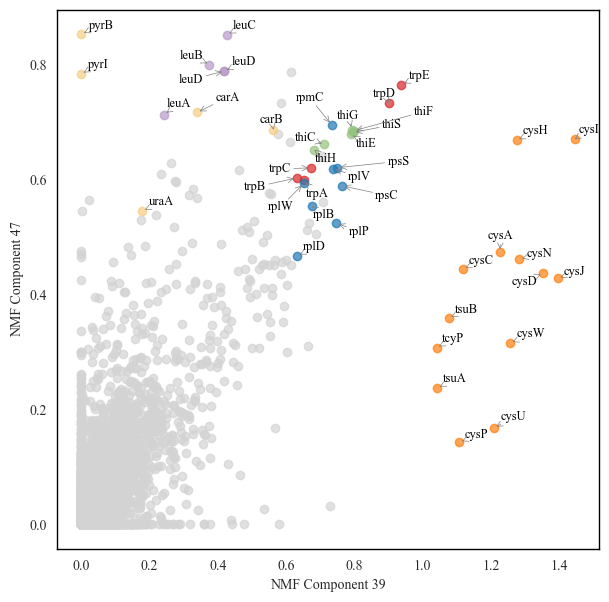

In [132]:
scatter_plot_with_annotations(components_pca, 'Component_39', 'Component_47', list1, list2, list3, list4, list5, list6,
                              x_label='NMF Component 39', y_label='NMF Component 47', save_as='High_MI_NMF_scatter_plot.svg')

In [149]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as mtick
def scatter_plot_with_annotations(df, col_x, col_y, 
                                  list1, list2, list3=None, list4=None, list5=None, list6=None, 
                                  x_label=None, y_label=None, save_as=None):
    """
    Creates a scatter plot of two specified columns from a dataframe,
    colors points based on up to six input lists of row indices, and annotates points from these lists.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    col_x (str): The name of the column for the x-axis.
    col_y (str): The name of the column for the y-axis.
    list1 (list): List of row indices for points to be colored in #f6cd82.
    list2 (list): List of row indices for points to be colored in #b899c8.
    list3 (list, optional): List of row indices for points to be colored in #94c47d. Default is None.
    list4 (list, optional): List of row indices for points to be colored in #1f77b4. Default is None.
    list5 (list, optional): List of row indices for points to be colored in #d62728. Default is None.
    list6 (list, optional): List of row indices for points to be colored in #ff7f0e. Default is None.
    x_label (str, optional): Custom label for the x-axis. If None, col_x is used.
    y_label (str, optional): Custom label for the y-axis. If None, col_y is used.
    save_as (str, optional): Path to save the figure as an SVG file. If None, the plot will just be shown.
    """
    # Load the custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Prepare the subsets for each list of points
    points_lists = [list1, list2, list3, list4, list5, list6]
    colors = ['#f6cd82', '#b899c8', '#94c47d', '#ff7f0e', '#d62728', '#1f77b4']
    
    # Filter points for each list, ignoring None
    points_data = [df.loc[plist] if plist else None for plist in points_lists]

    # Collect indices from all valid lists to exclude them from 'other points'
    all_indices = [idx for plist in points_lists if plist for idx in plist]
    other_points = df.drop(all_indices)

    # Scatter plot setup
    plt.figure(figsize=(3, 3))

    # Plot other points in light grey
    plt.scatter(other_points[col_x], other_points[col_y], alpha=0.7, color='lightgrey')

    # Plot points from each provided list with respective colors
    texts = []  # Collect text objects for annotation adjustment
    for pdata, color in zip(points_data, colors):
        if pdata is not None:
            plt.scatter(pdata[col_x], pdata[col_y], alpha=0.7, color=color)
            for idx, row in pdata.iterrows():
                texts.append(plt.text(row[col_x], row[col_y], str(idx), fontsize=9, 
                                      color='black', fontproperties=font_prop))

    # Adjust text to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), 
                force_points=0.3, force_text=0.3, 
                expand_points=(1.5, 1.5), expand_text=(1.5, 1.5))

    # Set x and y labels
    plt.xlabel(x_label if x_label else col_x, fontproperties=font_prop)
    plt.ylabel(y_label if y_label else col_y, fontproperties=font_prop)
    plt.ylim(-0.12,0.32)
    # Customize tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)
    ax = plt.gca()  # Get current axis
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    # Remove the grid
    plt.grid(False)

    # Add a black box around the plot
    ax = plt.gca()  # Get current axis
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Save or show the plot
    if save_as:
        plt.savefig(save_as, format='svg', bbox_inches='tight')
    else:
        plt.show()


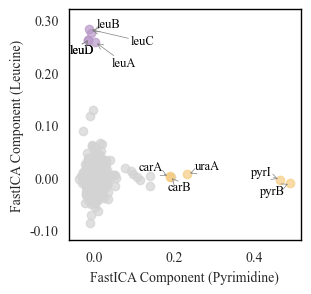

In [150]:
scatter_plot_with_annotations(components_ica, 'Pyrimidine', 'Leucine', list1, list2,
                              x_label='FastICA Component (Pyrimidine)', y_label='FastICA Component (Leucine)', save_as='NMF_example_1.svg')

In [153]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def scatter_plot_with_annotations(df, col_x, col_y, 
                                  list1, list2, list3=None, list4=None, list5=None, list6=None, 
                                  x_label=None, y_label=None, save_as=None, ):
    """
    Creates a scatter plot of two specified columns from a dataframe,
    colors points based on up to six input lists of row indices, and annotates points from these lists.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    col_x (str): The name of the column for the x-axis.
    col_y (str): The name of the column for the y-axis.
    list1 (list): List of row indices for points to be colored in #f6cd82.
    list2 (list): List of row indices for points to be colored in #b899c8.
    list3 (list, optional): List of row indices for points to be colored in #94c47d. Default is None.
    list4 (list, optional): List of row indices for points to be colored in #1f77b4. Default is None.
    list5 (list, optional): List of row indices for points to be colored in #d62728. Default is None.
    list6 (list, optional): List of row indices for points to be colored in #ff7f0e. Default is None.
    x_label (str, optional): Custom label for the x-axis. If None, col_x is used.
    y_label (str, optional): Custom label for the y-axis. If None, col_y is used.
    save_as (str, optional): Path to save the figure as an SVG file. If None, the plot will just be shown.
    """
    # Load the custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Prepare the subsets for each list of points
    points_lists = [list1, list2, list3, list4, list5, list6]
    colors = ['#d62728', '#1f77b4', '#94c47d', '#ff7f0e', '#b899c8', '#f6cd82']
    
    # Filter points for each list, ignoring None
    points_data = [df.loc[plist] if plist else None for plist in points_lists]

    # Collect indices from all valid lists to exclude them from 'other points'
    all_indices = [idx for plist in points_lists if plist for idx in plist]
    other_points = df.drop(all_indices)

    # Scatter plot setup
    plt.figure(figsize=(3, 3))

    # Plot other points in light grey
    plt.scatter(other_points[col_x], other_points[col_y], alpha=0.7, color='lightgrey')

    # Plot points from each provided list with respective colors
    texts = []  # Collect text objects for annotation adjustment
    for pdata, color in zip(points_data, colors):
        if pdata is not None:
            plt.scatter(pdata[col_x], pdata[col_y], alpha=0.7, color=color)
            for idx, row in pdata.iterrows():
                texts.append(plt.text(row[col_x], row[col_y], str(idx), fontsize=9, 
                                      color='black', fontproperties=font_prop))

    # Adjust text to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), 
                force_points=0.3, force_text=0.3, 
                expand_points=(1.5, 1.5), expand_text=(1.5, 1.5))

    # Set x and y labels
    plt.xlabel(x_label if x_label else col_x, fontproperties=font_prop)
    plt.ylabel(y_label if y_label else col_y, fontproperties=font_prop)
    plt.ylim(-0.06,0.16)
    # Customize tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)

    # Remove the grid
    plt.grid(False)

    # Add a black box around the plot
    ax = plt.gca()  # Get current axis
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Save or show the plot
    if save_as:
        plt.savefig(save_as, format='svg', bbox_inches='tight')
    else:
        plt.show()


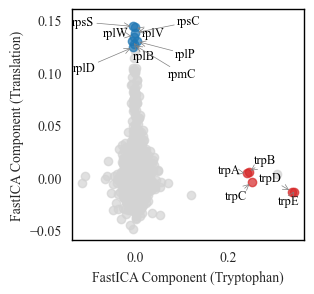

In [154]:
scatter_plot_with_annotations(components_ica, 'Tryptophan', 'Translation', list5, list6,
                              x_label='FastICA Component (Tryptophan)', y_label='FastICA Component (Translation)', save_as='NMF_example_2.svg')

In [123]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def scatter_plot_with_annotations(df, col_x, col_y, 
                                  list1, list2, list3=None, list4=None, list5=None, list6=None, 
                                  x_label=None, y_label=None, save_as=None, ):
    """
    Creates a scatter plot of two specified columns from a dataframe,
    colors points based on up to six input lists of row indices, and annotates points from these lists.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    col_x (str): The name of the column for the x-axis.
    col_y (str): The name of the column for the y-axis.
    list1 (list): List of row indices for points to be colored in #f6cd82.
    list2 (list): List of row indices for points to be colored in #b899c8.
    list3 (list, optional): List of row indices for points to be colored in #94c47d. Default is None.
    list4 (list, optional): List of row indices for points to be colored in #1f77b4. Default is None.
    list5 (list, optional): List of row indices for points to be colored in #d62728. Default is None.
    list6 (list, optional): List of row indices for points to be colored in #ff7f0e. Default is None.
    x_label (str, optional): Custom label for the x-axis. If None, col_x is used.
    y_label (str, optional): Custom label for the y-axis. If None, col_y is used.
    save_as (str, optional): Path to save the figure as an SVG file. If None, the plot will just be shown.
    """
    # Load the custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Prepare the subsets for each list of points
    points_lists = [list1, list2, list3, list4, list5, list6]
    colors = ['#94c47d', '#ff7f0e', '#d62728', '#1f77b4', '#b899c8', '#f6cd82']
    
    # Filter points for each list, ignoring None
    points_data = [df.loc[plist] if plist else None for plist in points_lists]

    # Collect indices from all valid lists to exclude them from 'other points'
    all_indices = [idx for plist in points_lists if plist for idx in plist]
    other_points = df.drop(all_indices)

    # Scatter plot setup
    plt.figure(figsize=(3, 3))

    # Plot other points in light grey
    plt.scatter(other_points[col_x], other_points[col_y], alpha=0.7, color='lightgrey')

    # Plot points from each provided list with respective colors
    texts = []  # Collect text objects for annotation adjustment
    for pdata, color in zip(points_data, colors):
        if pdata is not None:
            plt.scatter(pdata[col_x], pdata[col_y], alpha=0.7, color=color)
            for idx, row in pdata.iterrows():
                texts.append(plt.text(row[col_x], row[col_y], str(idx), fontsize=9, 
                                      color='black', fontproperties=font_prop))

    # Adjust text to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), 
                force_points=0.3, force_text=0.3, 
                expand_points=(1.5, 1.5), expand_text=(1.5, 1.5))

    # Set x and y labels
    plt.xlabel(x_label if x_label else col_x, fontproperties=font_prop)
    plt.ylabel(y_label if y_label else col_y, fontproperties=font_prop)

    # Customize tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)

    # Remove the grid
    plt.grid(False)

    # Add a black box around the plot
    ax = plt.gca()  # Get current axis
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Save or show the plot
    if save_as:
        plt.savefig(save_as, format='svg', bbox_inches='tight')
    else:
        plt.show()


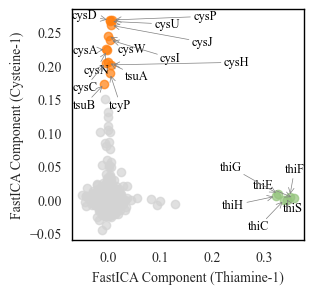

In [124]:
scatter_plot_with_annotations(components_ica, 'Thiamine-1', 'Cysteine-1', list3, list4,
                              x_label='FastICA Component (Thiamine-1)', y_label='FastICA Component (Cysteine-1)', save_as='NMF_example_3.svg')